In [1]:
!pip install --upgrade quantecon

In [2]:
!pip install --upgrade quantecon

In [3]:
import numpy as np
from quantecon import LQ
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from IPython.display import display, Math

In [4]:
class ChangLQ:
    """
    Class to solve LQ Chang model
    """
    def __init__(self, β, c, α=1, u0=1, u1=0.5, u2=3, T=1000, θ_n=200):
        # Record parameters
        self.α, self.u0, self.u1, self.u2 = α, u0, u1, u2
        self.β, self.c, self.T, self.θ_n = β, c, T, θ_n

        self.setup_LQ_matrices()
        self.solve_LQ_problem()
        self.compute_policy_functions()
        self.simulate_ramsey_plan()
        self.compute_θ_range()
        self.compute_value_and_policy()

    def setup_LQ_matrices(self):
        # LQ Matrices
        self.R = -np.array([[self.u0, -self.u1 * self.α / 2],
                            [-self.u1 * self.α / 2, 
                             -self.u2 * self.α**2 / 2]])
        self.Q = -np.array([[-self.c / 2]])
        self.A = np.array([[1, 0], [0, (1 + self.α) / self.α]])
        self.B = np.array([[0], [-1 / self.α]])

    def solve_LQ_problem(self):
        # Solve LQ Problem (Subproblem 1)
        lq = LQ(self.Q, self.R, self.A, self.B, beta=self.β)
        self.P, self.F, self.d = lq.stationary_values()

        # Compute g0, g1, and g2 (41.16)
        self.g0, self.g1, self.g2 = [-self.P[0, 0], 
                                     -2 * self.P[1, 0], -self.P[1, 1]]
        
        # Compute b0 and b1 (41.17)
        [[self.b0, self.b1]] = self.F

        # Compute d0 and d1 (41.18)
        self.cl_mat = (self.A - self.B @ self.F)  # Closed loop matrix
        [[self.d0, self.d1]] = self.cl_mat[1:]

        # Solve Subproblem 2
        self.θ_R = -self.P[0, 1] / self.P[1, 1]
        
        # Find the bliss level of θ
        self.θ_B = -self.u1 / (self.u2 * self.α)

    def compute_policy_functions(self):
        # Solve the Markov Perfect Equilibrium
        self.μ_MPE = -self.u1 / ((1 + self.α) / self.α * self.c 
                                 + self.α / (1 + self.α)
                                 * self.u2 + self.α**2 
                                 / (1 + self.α) * self.u2)
        self.θ_MPE = self.μ_MPE
        self.μ_CR = -self.α * self.u1 / (self.u2 * self.α**2 + self.c)
        self.θ_CR = self.μ_CR

        # Calculate value under MPE and CR economy
        self.J_θ = lambda θ_array: - np.array([1, θ_array]) \
                                   @ self.P @ np.array([1, θ_array]).T
        self.V_θ = lambda θ: (self.u0 + self.u1 * (-self.α * θ)
                              - self.u2 / 2 * (-self.α * θ)**2 
                              - self.c / 2 * θ**2) / (1 - self.β)
        
        self.J_MPE = self.V_θ(self.μ_MPE)
        self.J_CR = self.V_θ(self.μ_CR)

    def simulate_ramsey_plan(self):
        # Simulate Ramsey plan for large number of periods
        θ_series = np.vstack((np.ones((1, self.T)), np.zeros((1, self.T))))
        μ_series = np.zeros(self.T)
        J_series = np.zeros(self.T)
        θ_series[1, 0] = self.θ_R
        [μ_series[0]] = -self.F.dot(θ_series[:, 0])
        J_series[0] = self.J_θ(θ_series[1, 0])

        for i in range(1, self.T):
            θ_series[:, i] = self.cl_mat @ θ_series[:, i-1]
            [μ_series[i]] = -self.F @ θ_series[:, i]
            J_series[i] = self.J_θ(θ_series[1, i])

        self.J_series = J_series
        self.μ_series = μ_series
        self.θ_series = θ_series

    def compute_θ_range(self):
        # Find the range of θ in Ramsey plan
        θ_LB = min(min(self.θ_series[1, :]), self.θ_B)
        θ_UB = max(max(self.θ_series[1, :]), self.θ_MPE)
        θ_range = θ_UB - θ_LB
        self.θ_LB = θ_LB - 0.05 * θ_range
        self.θ_UB = θ_UB + 0.05 * θ_range
        self.θ_range = θ_range

    def compute_value_and_policy(self):        
        # Create the θ_space
        self.θ_space = np.linspace(self.θ_LB, self.θ_UB, 200)
        
        # Find value function and policy functions over range of θ
        self.J_space = np.array([self.J_θ(θ) for θ in self.θ_space])
        self.μ_space = -self.F @ np.vstack((np.ones(200), self.θ_space))
        x_prime = self.cl_mat @ np.vstack((np.ones(200), self.θ_space))
        self.θ_prime = x_prime[1, :]
        self.CR_space = np.array([self.V_θ(θ) for θ in self.θ_space])
        
        self.μ_space = self.μ_space[0, :]
        
        # Calculate J_range, J_LB, and J_UB
        self.J_range = np.ptp(self.J_space)
        self.J_LB = np.min(self.J_space) - 0.05 * self.J_range
        self.J_UB = np.max(self.J_space) + 0.05 * self.J_range

In [5]:
clq = ChangLQ(β=0.85, c=2)

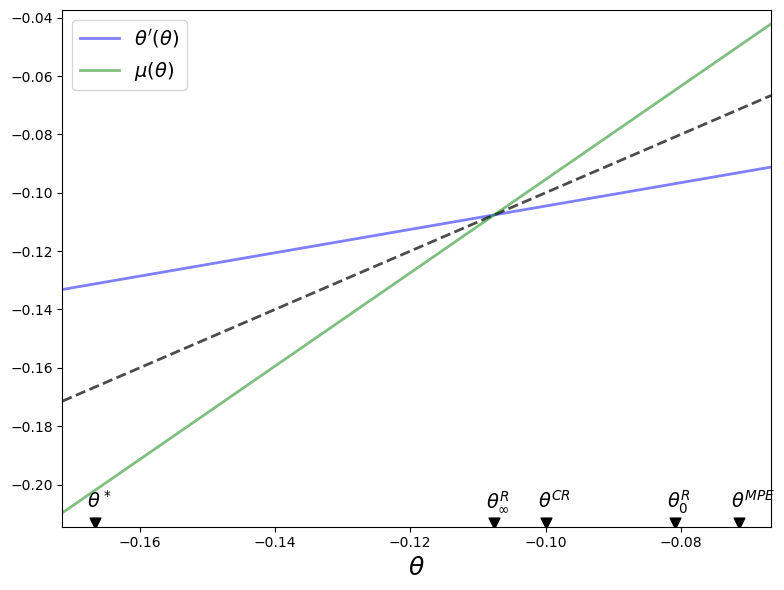

In [6]:
def compute_θs(clq):
    """
    Method to compute θ and assign corresponding labels and colors 

    Here clq is an instance of ChangLQ
    """
    θ_points = [clq.θ_B, clq.θ_series[1, -1], 
                clq.θ_CR, clq.θ_space[np.argmax(clq.J_space)], 
                clq.θ_MPE]
    labels = [r"$\theta^*$", r"$\theta_\infty^R$", 
              r"$\theta^{CR}$", r"$\theta_0^R$", 
              r"$\theta^{MPE}$"]
    θ_colors = ['r', 'C5', 'g', 'C0', 'orange']

    return θ_points, labels, θ_colors

def plot_policy_functions(clq):
    """
    Method to plot the policy functions over the relevant range of θ

    Here clq is an instance of ChangLQ
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    θ_points, labels, θ_colors = compute_θs(clq)

    # Plot θ' function
    ax.plot(clq.θ_space, clq.θ_prime, 
            label=r"$\theta'(\theta)$", 
            lw=2, alpha=0.5, color='blue')
    ax.plot(clq.θ_space, clq.θ_space, 'k--', lw=2, alpha=0.7)  # Identity line
    
    # Plot μ function
    ax.plot(clq.θ_space, clq.μ_space, lw=2, 
            label=r"$\mu(\theta)$", 
            color='green', alpha=0.5)

    # Plot labels and points for μ function
    μ_min, μ_max = min(clq.μ_space), max(clq.μ_space)
    μ_range = μ_max - μ_min
    offset = 0.02 * μ_range
    for θ, label in zip(θ_points, labels):
        ax.scatter(θ, μ_min - offset, 60, color='black', marker='v')
        ax.annotate(label, xy=(θ, μ_min - offset),
                    xytext=(θ - 0.012 * clq.θ_range, μ_min + 0.01 * μ_range),
                    fontsize=14)

    # Set labels and limits
    ax.set_xlabel(r"$\theta$", fontsize=18)
    ax.set_xlim([clq.θ_LB, clq.θ_UB])
    ax.set_ylim([min(clq.θ_LB, μ_min) - 0.05 * clq.θ_range, 
                 max(clq.θ_UB, μ_max) + 0.05 * clq.θ_range])
    
    # Add legend
    ax.legend(fontsize=14)

    plt.tight_layout()
    plt.show()

plot_policy_functions(clq)

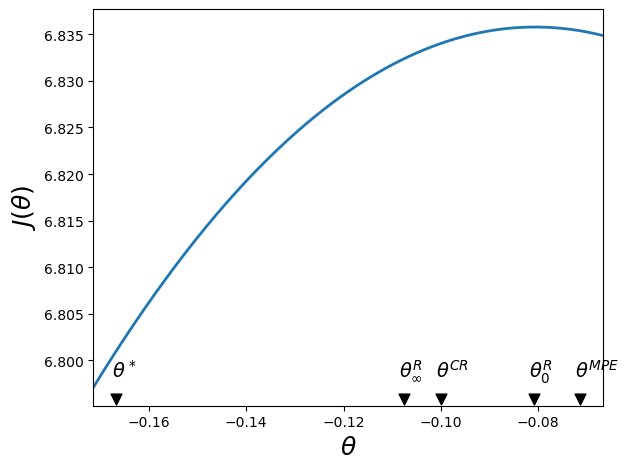

In [7]:
def plot_value_function(clq):
    """
    Method to plot the value function over the relevant range of θ

    Here clq is an instance of ChangLQ
    """
    fig, ax = plt.subplots()

    ax.set_xlim([clq.θ_LB, clq.θ_UB])
    ax.set_ylim([clq.J_LB, clq.J_UB])

    # Plot value function
    ax.plot(clq.θ_space, clq.J_space, lw=2)
    plt.xlabel(r"$\theta$", fontsize=18)
    plt.ylabel(r"$J(\theta)$", fontsize=18)

    θ_points, labels, _ = compute_θs(clq)

    # Add points for θs
    for θ, label in zip(θ_points, labels):
        ax.scatter(θ, clq.J_LB + 0.02 * clq.J_range, 
                   60, color='black', marker='v')
        ax.annotate(label,
                    xy=(θ, clq.J_LB + 0.01 * clq.J_range),
                    xytext=(θ - 0.01 * clq.θ_range, 
                            clq.J_LB + 0.08 * clq.J_range),
                    fontsize=14)
    plt.tight_layout()
    plt.show()
    
plot_value_function(clq)

In [8]:
θ_inf = clq.θ_series[1, -1]
np.allclose(clq.J_θ(θ_inf),
            clq.V_θ(θ_inf))

True

In [9]:
def compare_ramsey_CR(clq, ax):
    """
    Method to compare values of Ramsey and Constrained Ramsey (CR)

    Here clq is an instance of ChangLQ
    """
    
    # Calculate CR space range and bounds
    min_J, max_J = min(clq.J_space), max(clq.J_space)
    range_J = max_J - min_J
    l_J, u_J = min_J - 0.05 * range_J, max_J + 0.05 * range_J
    
    # Set axis limits
    ax.set_xlim([clq.θ_LB, clq.θ_UB])
    ax.set_ylim([l_J, u_J])

    # Plot J(θ) and v^CR(θ)
    CR_line, = ax.plot(clq.θ_space, clq.CR_space, lw=2, label=r"$V(\theta)$")
    J_line, = ax.plot(clq.θ_space, clq.J_space, lw=2, label=r"$J(\theta)$")
    
    # Mark key points
    θ_points, labels, θ_colors = compute_θs(clq)
    markers = [ax.scatter(θ, l_J + 0.02 * range_J, 60, 
                          marker='v', label=label, color=color)
               for θ, label, color in zip(θ_points, labels, θ_colors)]
    
    # Plot lines at \theta_\infty^R, \theta^{CR}, and \theta^{MPE}
    for i in [1, 2, -1]:
        ax.axvline(θ_points[i], ymin=0.05, lw=2, 
                   linestyle='--', color=θ_colors[i])
        ax.axhline(y=clq.V_θ(θ_points[i]), linestyle='dotted', 
                   lw=1.5, color=θ_colors[i], alpha=0.7)

    v_CR = clq.V_θ(θ_points[2])
    vcr_line = ax.axhline(y=v_CR, linestyle='--', lw=1.5, 
                          color='black', alpha=0.7, label=r"$v^{CR}$")

    return [J_line, CR_line, vcr_line], markers

def plt_clqs(clqs, axes):
    """
    A helper function to plot two separate legends on top and bottom

    Here clqs is a list of ChangLQ instances 
    axes is a list of Matplotlib axes
    """
    line_handles, scatter_handles = {}, {}
    
    if not isinstance(clqs, list): clqs, axes = [clqs], [axes]

    for ax, clq in zip(axes, clqs):
        lines, markers = compare_ramsey_CR(clq, ax)
        ax.set_title(fr'$\beta$={clq.β}, $c$={clq.c}')
        ax.tick_params(axis='x', rotation=45)

        line_handles.update({line.get_label(): line for line in lines})
        scatter_handles.update({marker.get_label(): marker for marker in markers})

    # Collect handles and labels
    line_handles = list(line_handles.values())
    scatter_handles = list(scatter_handles.values())

    # Create legends
    fig = plt.gcf()
    fig.legend(handles=line_handles, 
               labels=[line.get_label() for line in line_handles],
               loc='upper center', ncol=4, 
               bbox_to_anchor=(0.5, 1.1), prop={'size': 12})
    fig.legend(handles=scatter_handles, 
               labels=[marker.get_label() for marker in scatter_handles],
               loc='lower center', ncol=5, 
               bbox_to_anchor=(0.5, -0.1), prop={'size': 12})
    
    plt.tight_layout()
    plt.show()

def generate_table(clqs, dig=3):
    """
    A function to generate a table of θ values and display it using LaTeX

    Here clqs is a list of ChangLQ instances and 
    dig is the number of digits to round to
    """

    # Collect data
    label_maps = {rf'$\beta={clq.β}, c={clq.c}$': 
                  [f'{round(val, dig):.3f}' for val in compute_θs(clq)[0]] for clq in clqs}
    labels = compute_θs(clqs[0])[1]
    data_frame = pd.DataFrame(label_maps, index=labels)

    # Generate table
    columns = ' & '.join([f'\\text{{{col}}}' for col in data_frame.columns])
    rows = ' \\\\\n'.join(
        [' & '.join([f'\\text{{{label}}}'] + [f'{val}' for val in row]) 
         for label, row in zip(data_frame.index, data_frame.values)])

    latex_code = rf"""
    \begin{{array}}{{{'c' * (len(data_frame.columns) + 1)}}}
    & {columns} \\
    \hline
    {rows}
    \end{{array}}
    """
    
    display(Math(latex_code))

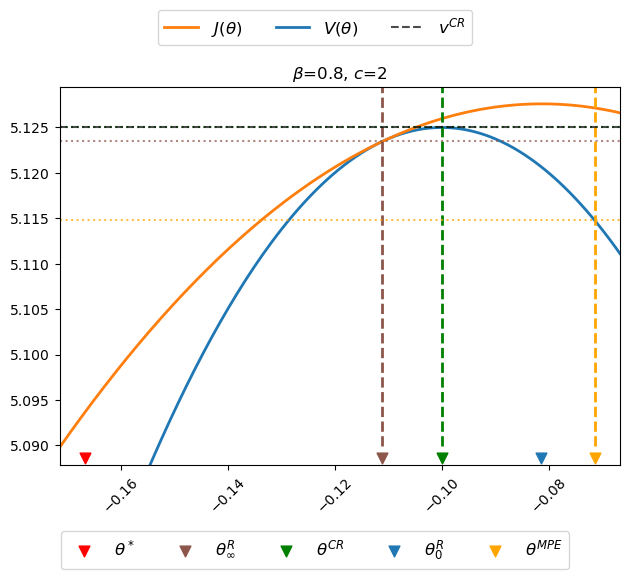

In [10]:
fig, ax = plt.subplots()
plt_clqs(ChangLQ(β=0.8, c=2), ax)

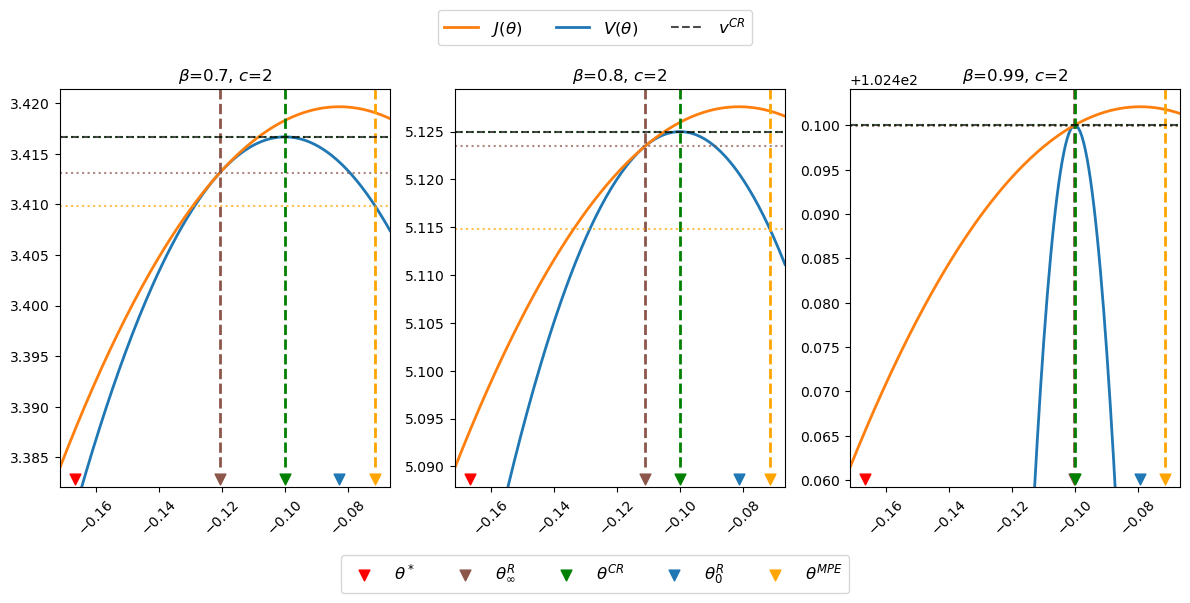

In [11]:
# Compare different β values
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
β_values = [0.7, 0.8, 0.99]

clqs = [ChangLQ(β=β, c=2) for β in β_values]
plt_clqs(clqs, axes)

In [12]:
generate_table(clqs, dig=3)

<IPython.core.display.Math object>

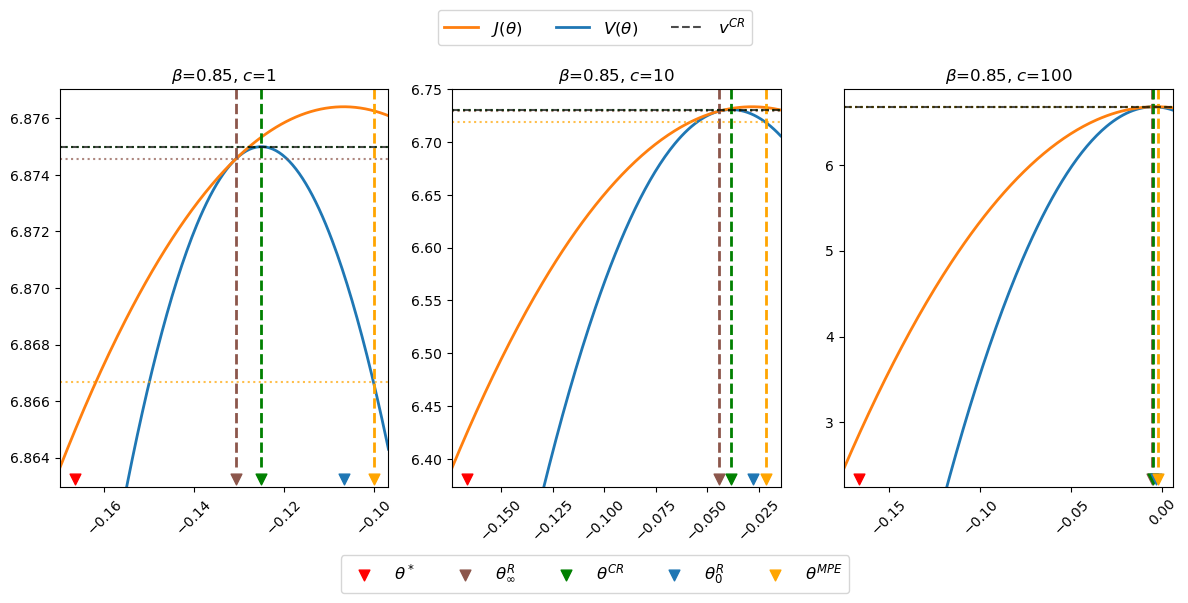

In [13]:
# Increase c to 100
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
c_values = [1, 10, 100]

clqs = [ChangLQ(β=0.85, c=c) for c in c_values]
plt_clqs(clqs, axes)

In [14]:
generate_table(clqs, dig=4)

<IPython.core.display.Math object>

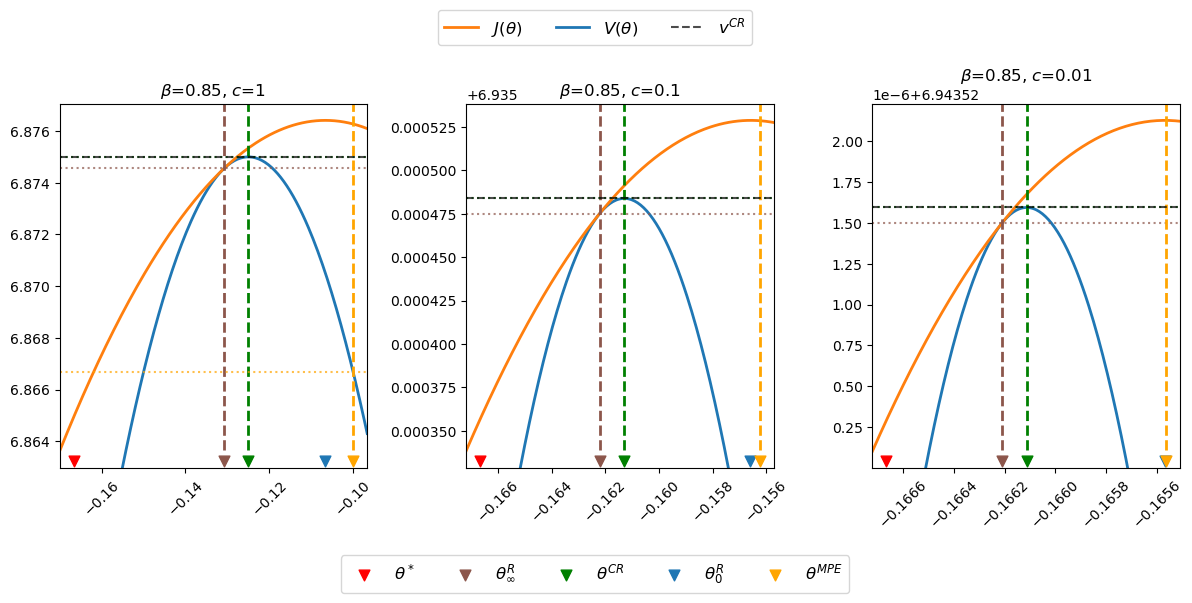

In [15]:
# Decrease c towards 0
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
c_limits = [1, 0.1, 0.01]

clqs = [ChangLQ(β=0.85, c=c) for c in c_limits]
plt_clqs(clqs, axes)

In [16]:
def plot_ramsey_MPE(clq, T=15):
    """
    Method to plot Ramsey plan against Markov Perfect Equilibrium

    Here clq is an instance of ChangLQ
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plots = [clq.θ_series[1, 0:T], clq.μ_series[0:T]]
    MPEs = [clq.θ_MPE, clq.μ_MPE]
    labels = [r"\theta", r"\mu"]

    for ax, plot, MPE, label in zip(axes, plots, MPEs, labels):
        ax.plot(plot, label=fr"${label}^R$")
        ax.hlines(MPE, 0, T-1, colors='orange', label=fr"${label}^{{MPE}}$")
        if label == r"\theta":
            ax.hlines(clq.θ_B, 0, T-1, colors='r', label=r"$\theta^*$")
        ax.hlines(clq.μ_CR, 0, T-1, colors='g', label=fr"${label}^{{CR}}$")
        ax.set_xlabel(r"$t$", fontsize=14)
        ax.set_ylabel(fr"${label}_t$", fontsize=16)
        ax.legend(loc='upper right')

    fig.suptitle(fr'$\beta$={clq.β}, $c$={clq.c}', fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

def generate_param_table(clq):
    """
    Method to generate a table of parameters

    Here clq is an instance of ChangLQ
    """

    # Collect data
    param_names = [r'$g_0$', r'$g_1$', r'$g_2$', 
                   r'$b_0$', r'$b_1$', r'$d_0$', r'$d_1$']
    params = [clq.g0, clq.g1, clq.g2, 
              clq.b0, clq.b1, clq.d0, clq.d1]

    # Generate table
    label = rf'$\beta={clq.β}, c={clq.c}$'
    data_frame = pd.DataFrame({label: params}, index=param_names).round(2).T

    columns = ' & '.join([f'\\text{{{col}}}' for col in data_frame.columns])
    rows = ' \\\\\n'.join([' & '.join([f'\\text{{{index}}}'] + [
        f'{val}' for val in row]) for index, row in data_frame.iterrows()])
    
    latex_code = rf"""
    \begin{{array}}{{{'c' * (len(data_frame.columns) + 1)}}}
    & {columns} \\
    \hline
    {rows}
    \end{{array}}
    """
    
    display(Math(latex_code))

<IPython.core.display.Math object>

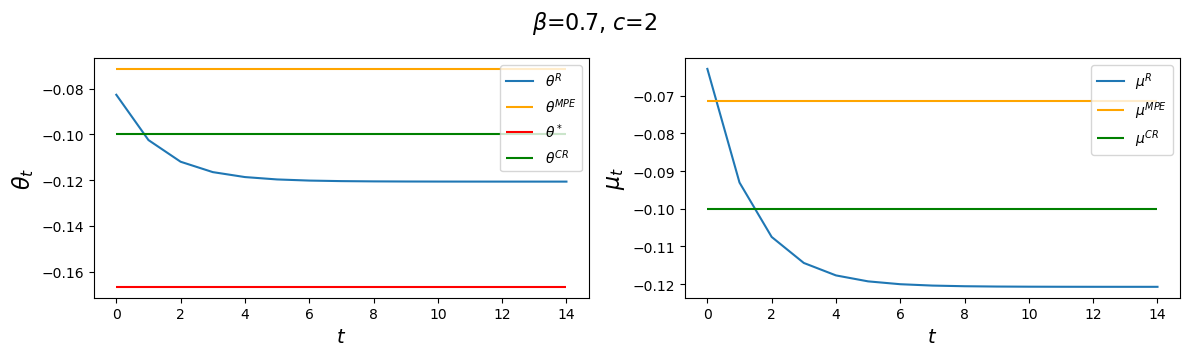

<IPython.core.display.Math object>

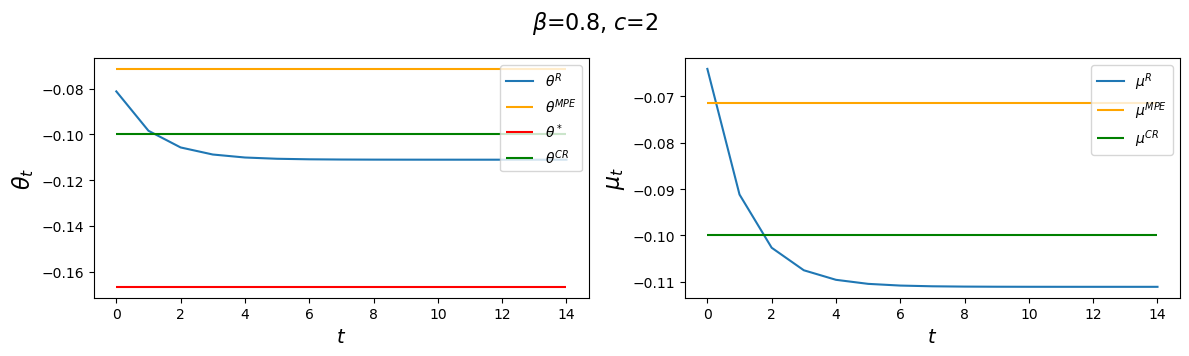

<IPython.core.display.Math object>

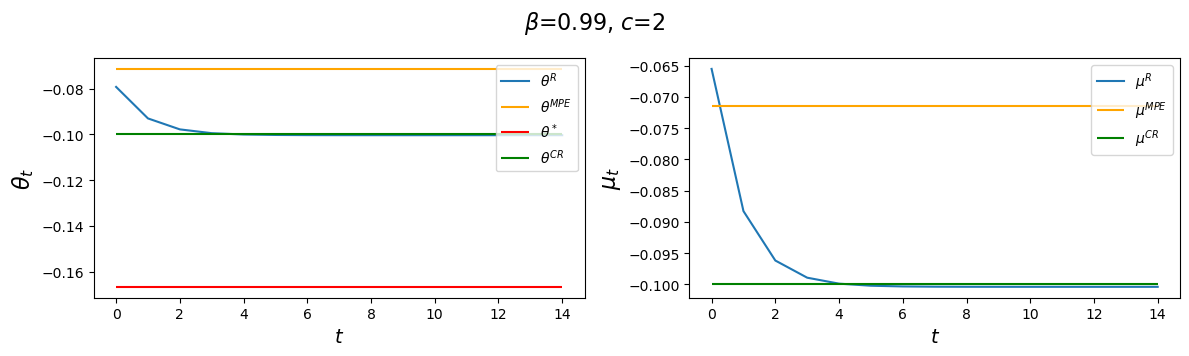

In [17]:
for β in β_values:
    clq = ChangLQ(β=β, c=2)
    generate_param_table(clq)
    plot_ramsey_MPE(clq)

<IPython.core.display.Math object>

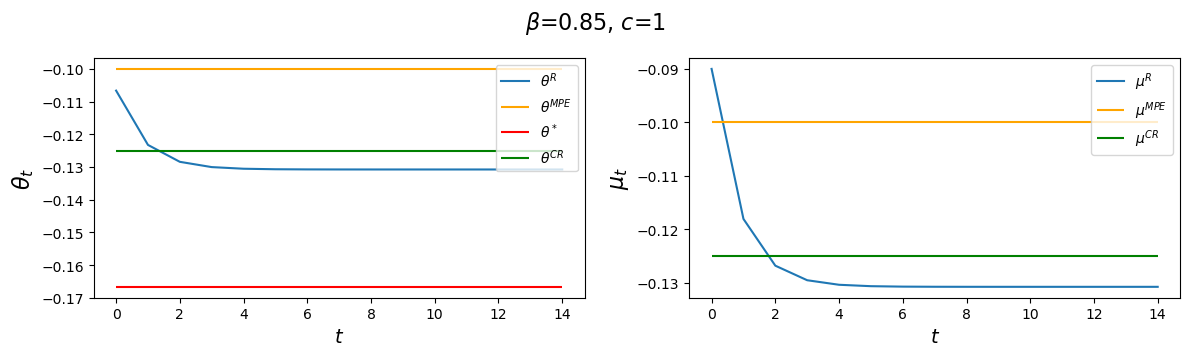

<IPython.core.display.Math object>

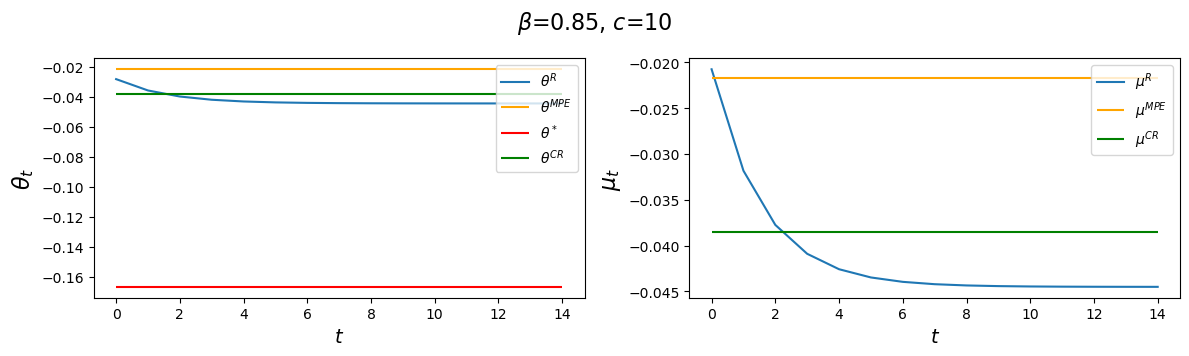

<IPython.core.display.Math object>

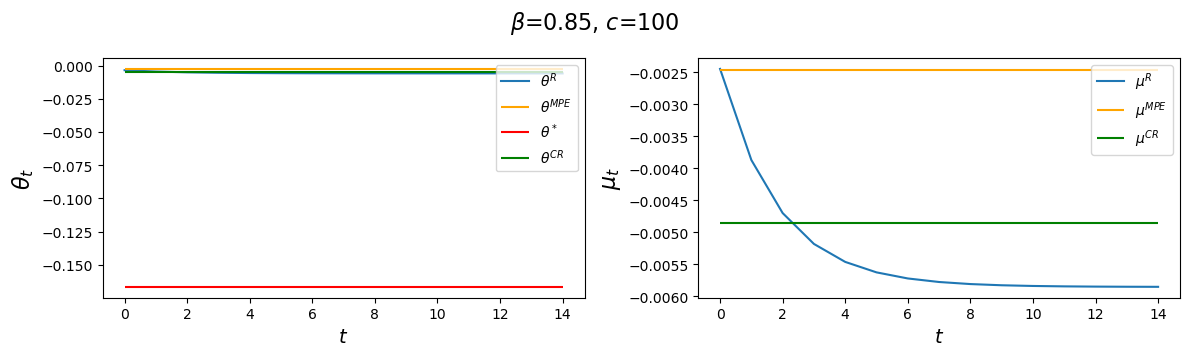

In [18]:
# Increase c to 100
for c in c_values:
    clq = ChangLQ(β=0.85, c=c)
    generate_param_table(clq)
    plot_ramsey_MPE(clq)

<IPython.core.display.Math object>

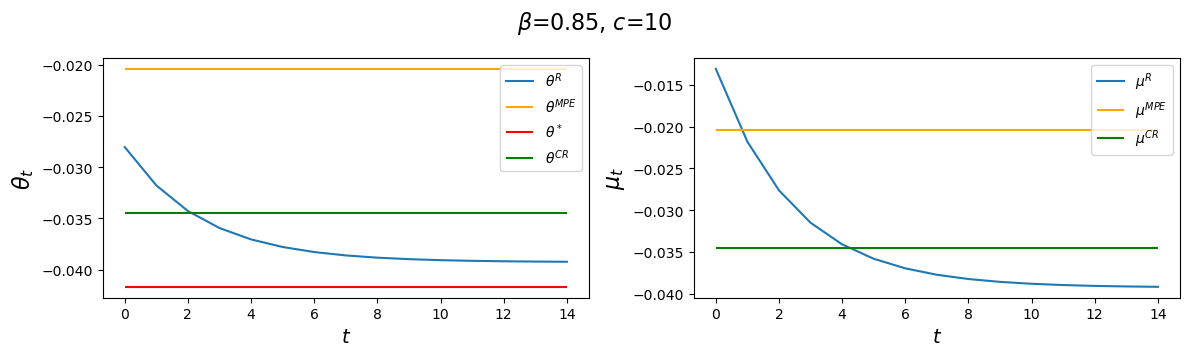

<IPython.core.display.Math object>

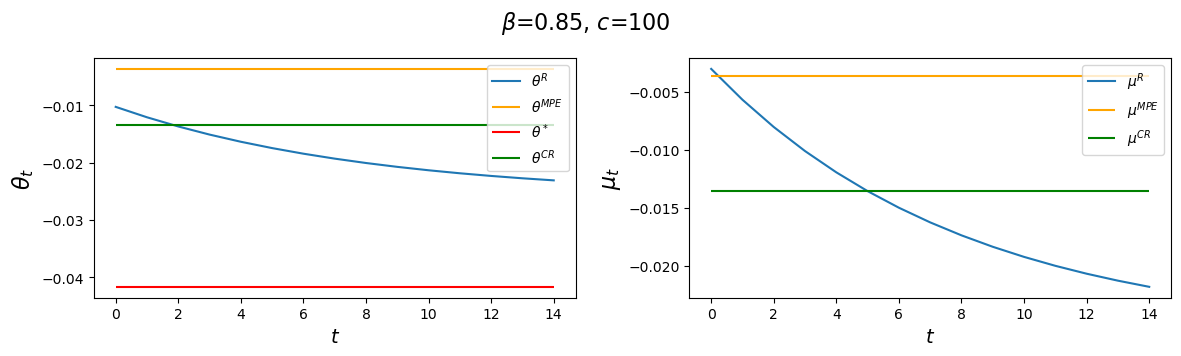

In [19]:
# Increase c to 100
for c in [10, 100]:
    clq = ChangLQ(α=4, β=0.85, c=c)
    generate_param_table(clq)
    plot_ramsey_MPE(clq)